# pm2.5 training notebook

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model, metrics, model_selection
from scipy import stats

from bs4 import BeautifulSoup

## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## crawler

In [4]:
station = str(467410)

def crawler(month, date):
    # create url
    
    mon = ''
    if month < 10:
        mon = '0' + str(month)
    else:
        mon = str(month)
    
    day = ''
    if date < 10:
        day = '0' + str(date)
    else:
        day = str(date)
    datepicker = '2019-' + mon + '-' + day
    
    # url: https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=467410&stname=&datepicker=2019-08-07
    url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=' + station + '&stname=&datepicker=' + datepicker
    # print(url)
    
    # request
    response = requests.get(url)
    # print(response.text)
    
    # html parsing
    soup = BeautifulSoup(response.text, features="html.parser")
    
#    title = ['WS', 'WD']
    
    # get the daily data
    body = soup.tbody
    trs = body.find_all('tr')
    trs = trs[3:]
    
    winddata = []
    hour = 0
    # extract wind speed and wind direction
    for tds in trs:
        sd = {}
        td = tds.find_all('td')
#        print(td[0].string)
#        print(td[6].string)
#        print(td[7].string)
#        print('---')
#        if td[7].string == "V\xa0":
#            td[7].string = "0"
        sd['month'] = month
        sd['day'] = date
        sd['hour'] = hour
        sd['speed'] = float(td[6].string)
#        sd.append(int(td[7].string))
        winddata.append(sd)
        hour += 1
    
    # turn the list to dataframe
    #df = pd.DataFrame(data=winddata, columns=title)
    
    return winddata

In [5]:
station = str(467410)

def crawler_rain(month, date):
    # create url
    
    mon = ''
    if month < 10:
        mon = '0' + str(month)
    else:
        mon = str(month)
    
    day = ''
    if date < 10:
        day = '0' + str(date)
    else:
        day = str(date)
    datepicker = '2019-' + mon + '-' + day
    
    # url: https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=467410&stname=&datepicker=2019-08-07
    url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=' + station + '&stname=&datepicker=' + datepicker
    # print(url)
    
    # request
    response = requests.get(url)
    # print(response.text)
    
    # html parsing
    soup = BeautifulSoup(response.text, features="html.parser")
    
#    title = ['WS', 'WD']
    
    # get the daily data
    body = soup.tbody
    trs = body.find_all('tr')
    trs = trs[3:]
    
    winddata = []
    hour = 0
    # extract wind speed and wind direction
    for tds in trs:
        sd = {}
        td = tds.find_all('td')
#        print(td[0].string)
#        print(td[6].string)
#        print(td[7].string)
#        print('---')
#        if td[7].string == "V\xa0":
#            td[7].string = "0"
        sd['month'] = month
        sd['day'] = date
        sd['hour'] = hour
        
        tmp = td[10].string
        if tmp == 'T\xa0':
            sd['rain'] = 0.0
        else:
            sd['rain'] = float(tmp)
#        sd.append(int(td[7].string))
        winddata.append(sd)
        hour += 1
    
    # turn the list to dataframe
    #df = pd.DataFrame(data=winddata, columns=title)
    
    return winddata

## Linear Regression

暫定的做法是：將每一小時的資料做平均，然後將下一小時的 pm2.5 平均當作想要預測的 y。如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。

### Load data


In [6]:
pos = 3
data3 = get_data_by_pos(pos)

In [7]:
df3 = pd.DataFrame(data3)

In [8]:
df3.head()

,date,humidity,pm10,pm100,pm25,temp
0,2019-05-11 09:28:17+08:00,62,50,94,78,28
1,2019-05-11 09:43:14+08:00,61,36,71,60,29
2,2019-05-11 09:58:13+08:00,59,39,75,63,29
3,2019-05-11 10:13:10+08:00,59,41,78,66,29
4,2019-05-11 10:28:07+08:00,59,33,67,52,30


### Data preprocessing

In [9]:
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]

In [10]:
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

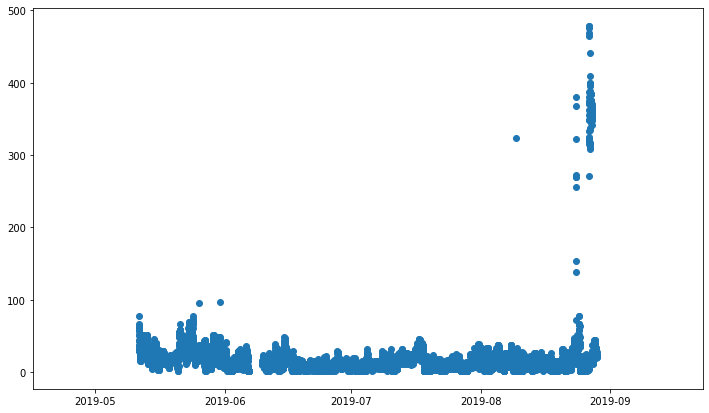

In [11]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df3['date'], df3['pm2.5'])

In [12]:
# Data cleaning
# want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
# df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 7).all(axis=1)]
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]

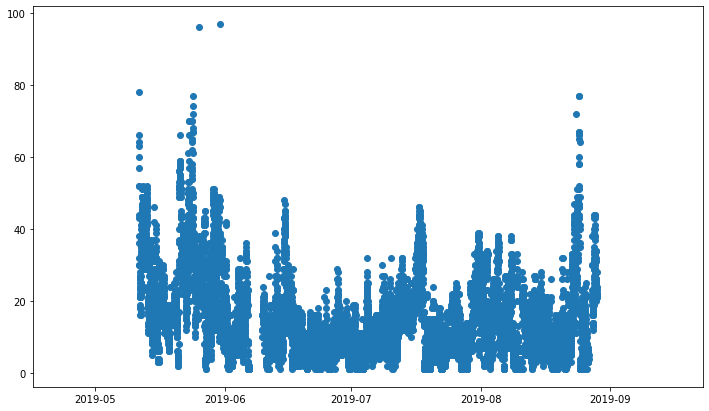

In [13]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df3['date'], df3['pm2.5'])

In [14]:
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)

In [15]:
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]

In [16]:
df3.head()

,month,day,weekday,hour,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,5,9,9.466667,50,78,94,28,62
1,5,11,5,9,9.716667,36,60,71,29,61
2,5,11,5,9,9.966667,39,63,75,29,59
3,5,11,5,10,10.216667,41,66,78,29,59
4,5,11,5,10,10.466667,33,52,67,30,59


In [17]:
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()

In [18]:
df3mean.head(10)

weekday  hour_minute      pm1.0  pm2.5  pm10.0       temp  \
month day hour                                                              
5     11  9         5.0     9.716667  41.666667  67.00   80.00  28.666667   
          10        5.0    10.591667  37.250000  59.75   72.75  29.750000   
          11        5.0    11.575000  28.500000  44.25   56.25  31.750000   
          12        5.0    12.575000  21.500000  32.00   37.00  35.000000   
          13        5.0    13.575000  18.500000  23.75   24.75  37.250000   
          14        5.0    14.575000  17.000000  22.50   23.50  37.750000   
          15        5.0    15.575000  19.000000  25.25   26.25  36.000000   
          16        5.0    16.575000  19.750000  26.50   29.00  32.500000   
          17        5.0    17.575000  14.250000  20.00   20.75  29.000000   
          18        5.0    18.575000  12.250000  17.25   18.75  27.000000   

                 humidity  
month day hour             
5     11  9     60.666667  
          10    58.000000  
          11    51.500000  
          12    43.500000  
          13    37.750000  
          14    36.750000  
          15    41.000000  
          16    49.500000  
          17    56.500000  
          18    61.500000

In [19]:
# Create hourly time
hourly = pd.period_range(start='2019-05-11', end='2019-08-30', freq='H')
hourlydf = pd.DataFrame(hourly, columns=['time'])

In [20]:
# Split time infomation
hourlydf['month'] = hourlydf['time'].apply(lambda x: x.month)
hourlydf['day'] = hourlydf['time'].apply(lambda x: x.day)
hourlydf['hour'] = hourlydf['time'].apply(lambda x: x.hour)
# Set index
hourlydf.set_index(['month', 'day', 'hour'], inplace=True)

In [21]:
# Concat !!!!!!!!
dfconcat = pd.concat([hourlydf, df3mean], axis=1, sort=False)
# Reset index
dfconcat.reset_index(inplace=True)

In [22]:
dfconcat.head()

,month,day,hour,time,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,0,2019-05-11 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,11,1,2019-05-11 01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,11,2,2019-05-11 02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,11,3,2019-05-11 03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,11,4,2019-05-11 04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)

In [24]:
dfconcat.head()

,month,day,hour,time,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,0,2019-05-10 23:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,11,1,2019-05-11 00:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,11,2,2019-05-11 01:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,11,3,2019-05-11 02:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,11,4,2019-05-11 03:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


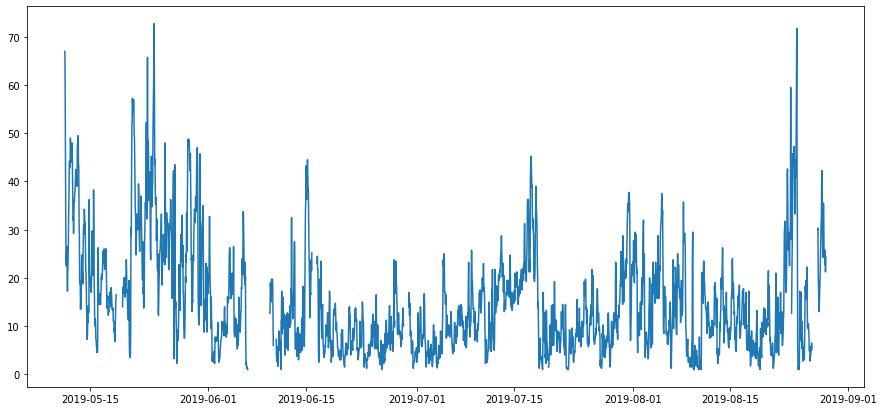

In [25]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(15, 7))
plt.plot(dfconcat['time'], dfconcat['pm2.5'])

In [26]:
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-1)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-1)

In [27]:
dfconcat.head()

,month,day,hour,time,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,pm2.5_shift,time_shift
0,5,11,0,2019-05-10 23:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 00:54:00+08:00
1,5,11,1,2019-05-11 00:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 01:54:00+08:00
2,5,11,2,2019-05-11 01:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 02:54:00+08:00
3,5,11,3,2019-05-11 02:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 03:54:00+08:00
4,5,11,4,2019-05-11 03:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 04:54:00+08:00


In [28]:
dfconcat.isna().sum()

month            0
day              0
hour             0
time             0
weekday        203
hour_minute    203
pm1.0          203
pm2.5          203
pm10.0         203
temp           203
humidity       203
pm2.5_shift    203
time_shift       1
dtype: int64

In [29]:
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)

In [30]:
dfconcat.isna().sum()

month          0
day            0
hour           0
time           0
weekday        0
hour_minute    0
pm1.0          0
pm2.5          0
pm10.0         0
temp           0
humidity       0
pm2.5_shift    0
time_shift     0
dtype: int64

### Normalization

$z = \frac{x- \mu}{\sigma}$


In [31]:
# Save mean and std
want_cols = ['pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'pm2.5_shift']
mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all

### Divid training set and test set

In [32]:
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

In [33]:
train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

### Select features

In [34]:
# 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed'
X = train_df[['temp', 'humidity']]
y = train_df[['pm2.5_shift']]

In [35]:
test_X = test_df[['temp', 'humidity']]
test_y = test_df[['pm2.5_shift']]

### Fit the model

using `sklearn.linear_model.LinearRegression`

In [36]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [37]:
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])

Coefficient for       temp:	-0.668276100903784
Coefficient for   humidity:	-0.711930669855668
Intercept: 			 -0.00759994242557574


In [38]:
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)

In [39]:
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

m = mean_all['pm2.5']
s = std_all['pm2.5']

test_df_ori = test_df['pm2.5'] * s + m

In [40]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Train MSE:	 109.968801,	 RMSE: 10.486601 (μg/m^3),	 MAPE:	 107.279477 %
Test MSE:	 125.412595,	 RMSE: 11.198776 (μg/m^3),	 MAPE:	 132.470121 %


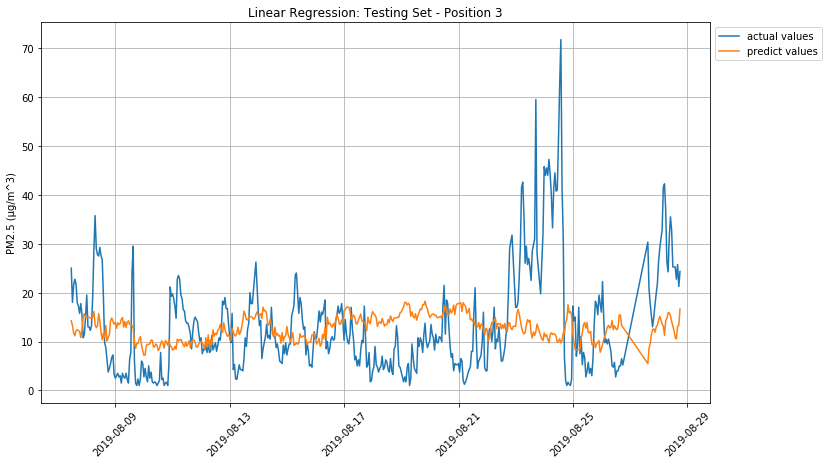

In [41]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

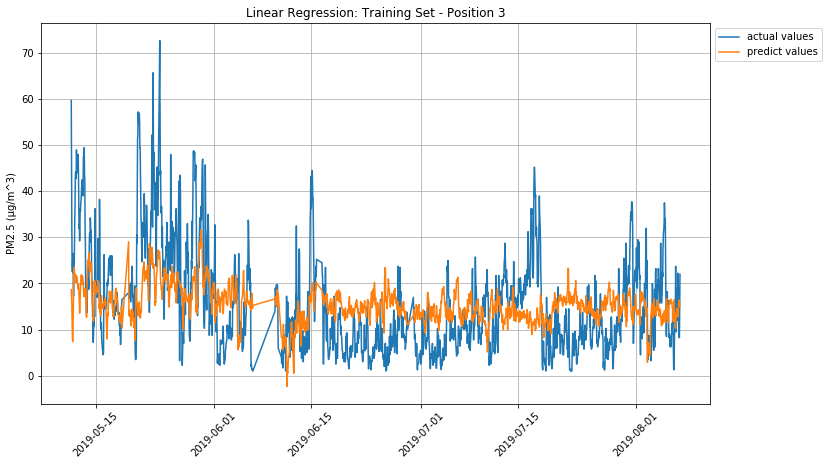

In [42]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(train_df['time_shift'], y_ori, label='actual values')
plt.plot(train_df['time_shift'], predict_train_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Training Set - Position %d' % pos)
plt.grid()
plt.show()

### Feature Selection via Ridge Regression

~~Our test error is worse than our training error. Therefore, our next job is to improve this.~~

Next, we improve mean squared error. 

We use the class `sklearn.linear_model.Ridge`. We will throw all features in, let ridge regression do selection, and see how our own feature sets compare. Notice we have an additional hyperparameter,  𝛼 . This controls how heavy the penalty is for larger weights.

To perform hyperparameter tuning we can use a technique called **cross validation**. We take our test set, randomly divide into  𝑘  training and testing sets. Differnent samples will be randomly placed in each set, each with their own variance. We then average the results over the folds to estimate how well we will do on unseen test data. After splitting the data into  𝑘  folds (10 is a usual choice for  𝑘 ), we will try out different hyperparameter values and select the best one. Much of this process is already wrapped in `sklearn.model_selection.cross_val_score` for us. We just need to define a scoring function.


In [43]:
# Define a scoring function
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [44]:
# Define a range of values for alpha to search over.
alphas = np.linspace(start=0, stop=100, num=11)

mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, X, y, cv=10, scoring=scorer)
    mses.append(mse.mean())

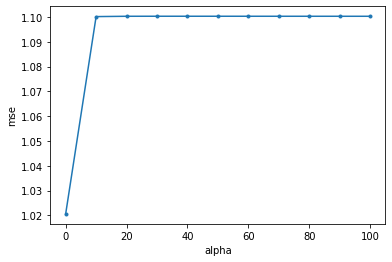

In [45]:
plt.plot(alphas, mses, marker='.')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [46]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.0

In [47]:
# Use `best_alpha` to fit the model
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(X, y)

Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [48]:
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], ridge.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])

Coefficient for       temp:	-0.6682761009037841
Coefficient for   humidity:	-0.7119306698556686
Intercept: 			 -0.00759994242557574


In [49]:
# Calculate mean squared error for training set & test set
predict_train_y = ridge.predict(X)
predict_y = ridge.predict(test_X)

In [50]:
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

m = mean_all['pm2.5']
s = std_all['pm2.5']

test_df_ori = test_df['pm2.5'] * s + m

In [51]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Train MSE:	 109.968801,	 RMSE: 10.486601 (μg/m^3),	 MAPE:	 107.279477 %
Test MSE:	 125.412595,	 RMSE: 11.198776 (μg/m^3),	 MAPE:	 132.470121 %


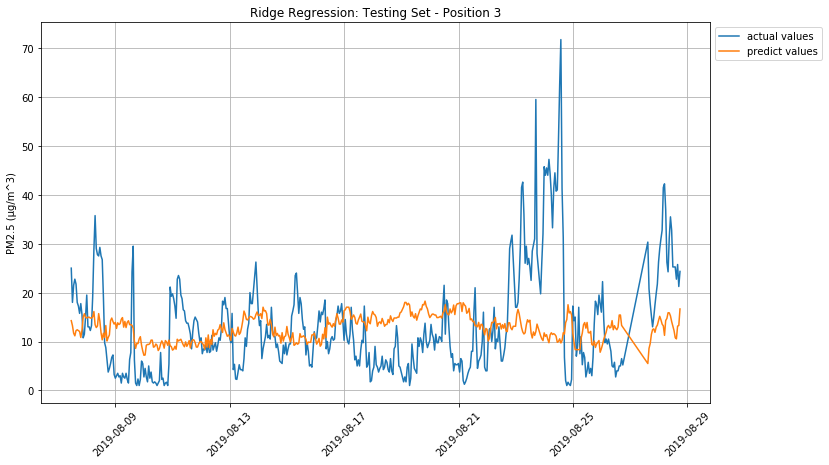

In [52]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Ridge Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

### Add wind speed

In [53]:
wind_data = []
for month in [5, 6, 7, 8]:
    if month == 5:
        r = range(11, 32)
    elif month == 6:
        r = range(1, 31)
    elif month == 7:
        r = range(1, 32)
    elif month == 8:
        r = range(1, 28)
    for day in r:
        tmp = crawler(month, day)
        wind_data = wind_data + tmp

In [54]:
wind = pd.DataFrame(wind_data)

In [55]:
wind.set_index(['month', 'day', 'hour'], inplace=True)

In [56]:
# Load data
pos = 3
data3 = get_data_by_pos(pos)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Data cleaning
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()

In [57]:
# Concat !!!!!!!!
dfconcat = pd.concat([df3mean, wind], axis=1, sort=False)

Coefficient for       temp:	-0.5655788603637246
Coefficient for   humidity:	-0.6511947524323181
Coefficient for      speed:	-0.22886886240163726
Intercept: 			 -0.025400839642812374
Train MSE:	 106.231347,	 RMSE: 10.306859 (μg/m^3),	 MAPE:	 99.630680 %
Test MSE:	 115.864470,	 RMSE: 10.764036 (μg/m^3),	 MAPE:	 98.324439 %


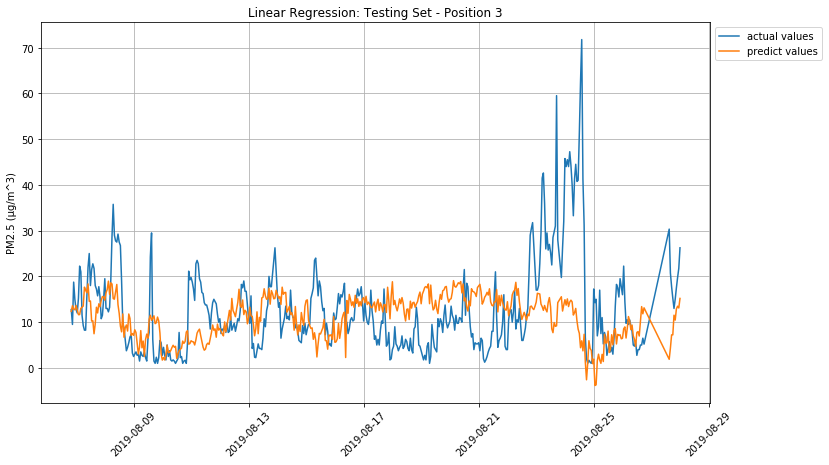

In [58]:
# Reset index
dfconcat.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-1)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-1)
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)
# Save mean and std
want_cols = ['pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed', 'pm2.5_shift']
mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

# 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed'
X = train_df[['temp', 'humidity', 'speed']]
y = train_df[['pm2.5_shift']]

test_X = test_df[['temp', 'humidity', 'speed']]
test_y = test_df[['pm2.5_shift']]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

m = mean_all['pm2.5']
s = std_all['pm2.5']

test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

### Add rainfall

In [59]:
rain_data = []
for month in [5, 6, 7, 8]:
    if month == 5:
        r = range(11, 32)
    elif month == 6:
        r = range(1, 31)
    elif month == 7:
        r = range(1, 32)
    elif month == 8:
        r = range(1, 28)
    for day in r:
        tmp = crawler_rain(month, day)
        rain_data = rain_data + tmp

In [60]:
rain = pd.DataFrame(rain_data)

In [61]:
rain.set_index(['month', 'day', 'hour'], inplace=True)

In [62]:
dfconcat = pd.concat([df3mean, wind, rain], axis=1, sort=False)

Coefficient for       temp:	-0.5640609057161057
Coefficient for   humidity:	-0.6428717939018613
Coefficient for      speed:	-0.2243659868993303
Coefficient for       rain:	-0.009046579196651711
Intercept: 			 -0.019102302479833043
Train MSE:	 106.126532,	 RMSE: 10.301773 (μg/m^3),	 MAPE:	 99.582283 %
Test MSE:	 114.614361,	 RMSE: 10.705810 (μg/m^3),	 MAPE:	 97.915655 %


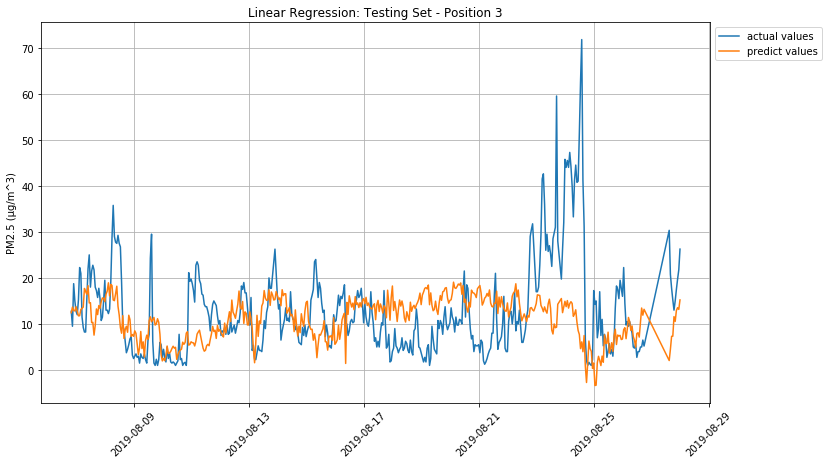

In [63]:
dfconcat.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-1)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-1)
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)
# Save mean and std
want_cols = ['pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed', 'pm2.5_shift']
mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

# 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed'
X = train_df[['temp', 'humidity', 'speed', 'rain']]
y = train_df[['pm2.5_shift']]

test_X = test_df[['temp', 'humidity', 'speed', 'rain']]
test_y = test_df[['pm2.5_shift']]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

m = mean_all['pm2.5']
s = std_all['pm2.5']

test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

## Polynomial Regression

In [64]:
# Load data
pos = 3
data3 = get_data_by_pos(pos)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Data cleaning
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)


In [65]:
df3['ts'] = df3['temp'].apply(lambda x: x**2)
df3['hs'] = df3['humidity'].apply(lambda x: x**2)
wind['ss'] = wind['speed'].apply(lambda x: x**2)
rain['rl'] = rain['rain'].apply(lambda x: np.sqrt(x))

Coefficient for         ts:	-0.3848373195308753
Coefficient for         hs:	-0.4640774500365563
Coefficient for      speed:	-0.22416071878917954
Coefficient for         rl:	-0.05974832034879988
Intercept: 			 -0.013963990575056213
Train MSE:	 109.629339,	 RMSE: 10.470403 (μg/m^3),	 MAPE:	 100.140220 %
Test MSE:	 104.955188,	 RMSE: 10.244764 (μg/m^3),	 MAPE:	 102.402521 %


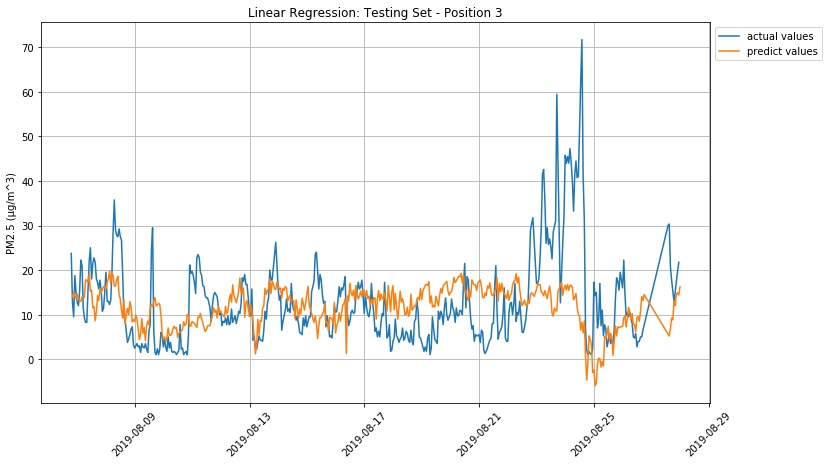

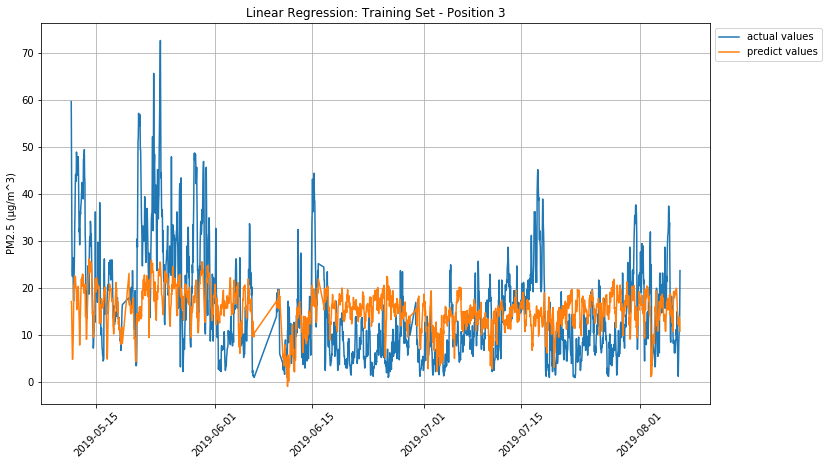

In [66]:
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'hs', 'ts']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
# Concat !!!!!!!!
dfconcat = pd.concat([df3mean, wind, rain], axis=1, sort=False)
# Reset index
dfconcat.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-1)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-1)
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)
# Save mean and std
feature_cols = ['ts', 'hs', 'speed', 'rl']
label_cols = ['pm2.5_shift']
want_cols = feature_cols + label_cols

mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

X = train_df[feature_cols]
y = train_df[label_cols]

test_X = test_df[feature_cols]
test_y = test_df[label_cols]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

#m = mean_all['pm2.5']
#s = std_all['pm2.5']

#test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df['time'], test_df_ori, label='actual values')
# plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(train_df['time_shift'], y_ori, label='actual values')
plt.plot(train_df['time_shift'], predict_train_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Training Set - Position %d' % pos)
plt.grid()
plt.show()

## Input all positions data

In [67]:
# Load data
data3 = get_all_data()
df3 = pd.DataFrame(data3)
# Input time
time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Data cleaning
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)

In [68]:
# Select position 0~7
df3 = df3.loc[ df3['position'] <= 7 ]

In [69]:
# Set the order of the columns & discard some columns
df = df3.drop(columns=['_cls', 'date'])
# Evaluate mean values for each hour
dfmean = df.groupby(['month', 'day', 'hour', 'position']).mean()

In [70]:
big_wind = None
tmp = wind.reset_index()
tmp['position'] = 0
big_wind = tmp

In [71]:
for i in range(1, 8):
    tmp = wind.reset_index()
    tmp['position'] = i
    big_wind = pd.concat([big_wind, tmp], ignore_index=True)

In [72]:
big_wind.set_index(['month', 'day', 'hour', 'position'], inplace=True)

In [73]:
big_rain = None
tmp = rain.reset_index()
tmp['position'] = 0
big_rain = tmp

for i in range(1, 8):
    tmp = rain.reset_index()
    tmp['position'] = i
    big_rain = pd.concat([big_rain, tmp], ignore_index=True)
    
big_rain.set_index(['month', 'day', 'hour', 'position'], inplace=True)

In [74]:
dfconcat = pd.concat([dfmean, big_wind, big_rain], axis=1, sort=False)

In [75]:
# Reset index
dfconcat.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)

In [76]:
dum = pd.get_dummies(dfconcat['position'], prefix='position')
dfconcat = pd.concat([dfconcat, dum], axis=1, sort=False)

In [77]:
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-1)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-1)
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)
# Save mean and std
cat_cols = ['position_0', 'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'position_6', 'position_7']
cal_cols = ['temp', 'humidity', 'speed', 'rain']
label_cols = ['pm2.5_shift']
feature_cols = cat_cols + cal_cols
want_cols = cal_cols + label_cols

mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

X = train_df[feature_cols]
y = train_df[label_cols]

test_X = test_df[feature_cols]
test_y = test_df[label_cols]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

#m = mean_all['pm2.5']
#s = std_all['pm2.5']

#test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Coefficient for position_0:	2303460375723.198
Coefficient for position_1:	2303460375723.1016
Coefficient for position_2:	2303460375723.033
Coefficient for position_3:	2303460375723.0513
Coefficient for position_4:	2303460375723.069
Coefficient for position_5:	2303460375722.912
Coefficient for position_6:	2303460375723.0913
Coefficient for position_7:	2303460375723.352
Coefficient for       temp:	0.1432773576045648
Coefficient for   humidity:	0.06696020627042562
Coefficient for      speed:	-0.1490606773391915
Coefficient for       rain:	-0.05722358440128058
Intercept: 			 -2303460375723.133
Train MSE:	 106.440766,	 RMSE: 10.317013 (μg/m^3),	 MAPE:	 105.056970 %
Test MSE:	 146.487954,	 RMSE: 12.103221 (μg/m^3),	 MAPE:	 92.852504 %


In [78]:
pd.set_option('display.max_columns', None)

In [79]:
test_df['predict_y_ori'] = predict_y_ori
test_df['test_y_ori'] = test_y_ori
train_df['y_ori'] = y_ori
train_df['predict_train_y_ori'] = predict_train_y_ori

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [80]:
# Select the duration
test_df3 = test_df.loc[ test_df['position'] == 3 ]
train_df3 = train_df.loc[ train_df['position'] == 3 ]

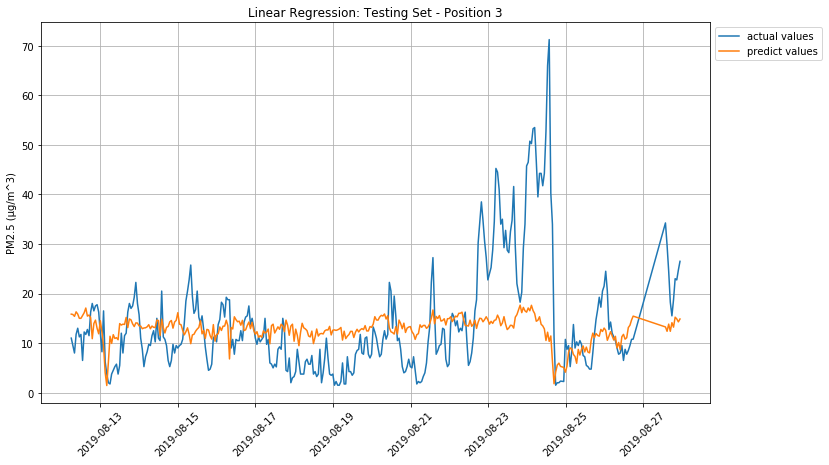

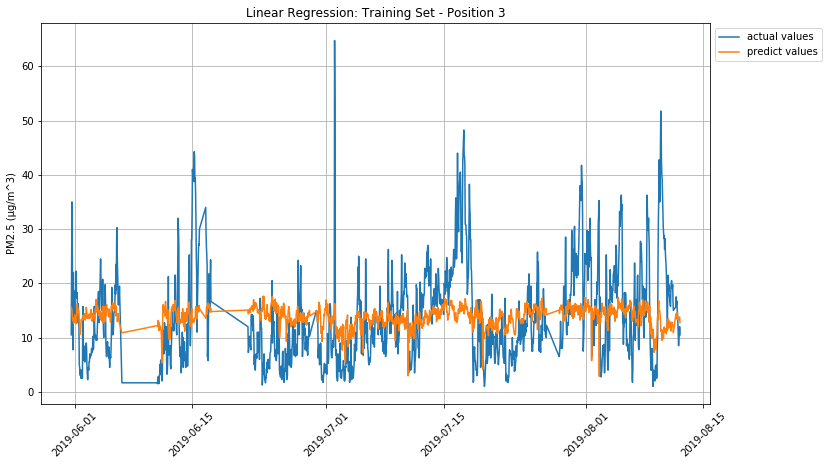

In [82]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df3['time'], test_df_ori, label='actual values')
plt.plot(test_df3['time_shift'], test_df3['test_y_ori'], label='actual values')
plt.plot(test_df3['time_shift'], test_df3['predict_y_ori'], label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(train_df3['time_shift'], train_df3['y_ori'], label='actual values')
plt.plot(train_df3['time_shift'], train_df3['predict_train_y_ori'], label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Training Set - Position %d' % pos)
plt.grid()
plt.show()